## Segmenting and Clustering Neighbourhoods in Toronto

This notebook will scrape the web site wikipedia for Toronto data and perform the requisite analysis

In [1]:
# Import Modules
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
!conda install -c conda-forge geopy --yes

# For the website Scrape
!conda install -c conda-forge lxml --yes
from lxml import etree

print('Modules Imported')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         147 KB

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.1-hecc5488_0 --> 2020.4.5.2-hecda079_0



ca-certificates-2020 | 147 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Modules Imported


In [2]:
# We have to scrape a website to get our data, this is done below
page = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

df_Postal = pd.DataFrame(page[0])
df_Postal.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Cleaning Dataframe to account for 'Not Assigned' values, Duplicate Postal Codes have already been accounted for on the website now

In [3]:
# Some Borough are Not assigned, some Neighborhood are not assigned, we need to clean this dataframe

# Only Process Cells with an assigned Borough
df_Postal = df_Postal.loc[df_Postal['Borough'] != 'Not assigned']

# Match unassigned neighbourhoods to their Borough name
df_Postal.loc[df_Postal['Neighborhood']=='Not assigned', 'Neighborhood'] = df_Postal['Borough']

# This isn't required anymore but included for posterity
df_Postal = df_Postal.groupby(by=['Postal Code','Borough']).agg(lambda x: ','.join(x)) 
df_Postal.reset_index(level=['Postal Code','Borough'], inplace=True) 

## Question 1: Dataframe Results

In [4]:
# Final Results of Dataframe portion of the report
print('Shape of Final Dataframe is: ')
print(df_Postal.shape)
df_Postal.head()

Shape of Final Dataframe is: 
(103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Q2 Finding Lat and Long Coordinates of all our postal codes

In [5]:
# Use the csv to find postcodes lat and long
df_latlong = pd.read_csv('http://cocl.us/Geospatial_data')

In [7]:
# Merge Data Frames on Postal Code
df = pd.merge(df_Postal, df_latlong, on='Postal Code')
df.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Q3 Exploring the Dataset and Produce a clustering analysis for neighborhoods in Toronto

In [38]:
# Search for the Toronto String, gives us 39 boroughs to have a peek at.
dfT = df[df['Borough'].str.contains("Toronto")]

In [39]:
# Our Foursquare Creds
CLIENT_ID = '3PUCFEWG2OS5ETYV55CEWNR1IG0DOE2ROZOJ1UFBZZN1V5OX' # your Foursquare ID
CLIENT_SECRET = '2X3231Z44OHX1TP5UYO1GMIXSCTPVAT13TAEGZNJFYOVPLHI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 3PUCFEWG2OS5ETYV55CEWNR1IG0DOE2ROZOJ1UFBZZN1V5OX
CLIENT_SECRET:2X3231Z44OHX1TP5UYO1GMIXSCTPVAT13TAEGZNJFYOVPLHI


### We are going to explore the same analysis as the lab so let's create a function to get nearest venues for our Postcodes in Toronto

In [48]:
import json # library to handle JSON files
import requests # library to handle requests

In [50]:
# Here is our Function to scan the Postcodes
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    ''' Our Function will get up to 100 nearest venues in a 500 metre radius of the coordinates'''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Scan all the Boroughs in Toronto
Toronto_venues = getNearbyVenues(names=dfT['Postal Code'],
                                   latitudes=dfT['Latitude'],
                                   longitudes=dfT['Longitude']
                                  )
Toronto_venues.head()

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7A
M7Y


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [150]:
# We have some venues and categories so lets analyse them
print('Data frame size is ' + str(Toronto_venues.shape))
print('There are {} unique categories.'.format(len(Toronto_venues['Venue Category'].unique())))

# Look at our dtypes and null counts
Toronto_venues.info()

Data frame size is (1615, 7)
There are 236 unique categories.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Postcode            1615 non-null   object 
 1   Postcode Latitude   1615 non-null   float64
 2   Postcode Longitude  1615 non-null   float64
 3   Venue               1615 non-null   object 
 4   Venue Latitude      1615 non-null   float64
 5   Venue Longitude     1615 non-null   float64
 6   Venue Category      1615 non-null   object 
dtypes: float64(4), object(3)
memory usage: 88.4+ KB


### Use One Hot Encoding to prepare for clustering by venue category but lets look at Restaurants Only

In [198]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

Toronto_onehot = Toronto_onehot.filter(regex='Restaurant')

# add Borough column back to dataframe
Toronto_onehot = pd.concat([Toronto_venues['Postcode'],Toronto_onehot],axis=1) 

#Let's Group by Postcode and take the mean for each category
Toronto_grouped = Toronto_onehot.groupby('Postcode').mean().reset_index()
print('Our Data Frame shape is ' + str(Toronto_grouped.shape))
Toronto_grouped.head()

Our Data Frame shape is (39, 45)


,Postcode,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Doner Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M4E,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000,0.0,0.0,0.0
1,M4K,0.0,0.023256,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.186047,0.023256,0.069767,0.023256,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.046512,0.000,0.000000,0.0,0.000,0.0,0.0,0.0
2,M4L,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.000000,0.000000,0.045455,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.000,0.045455,0.0,0.000,0.0,0.0,0.0
3,M4M,0.0,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.025000,0.000000,0.0,0.025,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.025,0.000000,0.0,0.025,0.0,0.0,0.0
4,M4N,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000,0.0,0.0,0.0


### We have our data needed for clustering so let's do that first before performing some visualisation

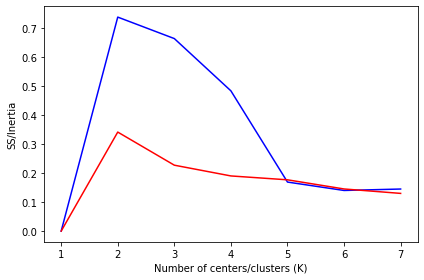

In [199]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

Toronto_grouped_clustering = Toronto_grouped.drop('Postcode', 1)

# find the best K with silhouette score and Inertia

Ks = 8 # number of ks we will test
SS = np.zeros((Ks-1))
inertia = np.zeros((Ks-1))

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for n in range(2, Ks):
    kmeans = KMeans(n_clusters = n, random_state = 0).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    SS[n-1] = silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean')
    inertia[n-1] = kmeans.inertia_
    
# plot the score
plt.plot(range(1,Ks),SS,'b')
plt.plot(range(1,Ks),inertia,'r')
plt.ylabel('SS/Inertia')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

### kMeans with 3 looks to be at an elbow with a strong silhouette score

In [200]:
# set number of clusters to 3
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [201]:
# Lets return the top 5 restaurant types of each postcode with this function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top 5 restaurant types for each postcode

In [202]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
Postcode_venues_sorted = pd.DataFrame(columns=columns)
Postcode_venues_sorted['Postcode'] = Toronto_grouped['Postcode']

for ind in np.arange(Toronto_grouped.shape[0]):
    Postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

# add clustering labels

Postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Postcode_venues_sorted.head(5)

,Cluster Labels,Postcode,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,0,M4E,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
1,0,M4K,Greek Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Caribbean Restaurant
2,0,M4L,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant
3,0,M4M,American Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,Thai Restaurant,Italian Restaurant
4,0,M4N,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant


In [203]:
#Merge with orginal data
Toronto_merged = dfT
Toronto_merged = Toronto_merged.rename(columns={'Postal Code': 'Postcode'}, errors="raise")
Toronto_merged = Toronto_merged.set_index('Postcode')

# merge toronto_grouped with toronto_data to add latitude/longitude for each cluster
Toronto_merged = Toronto_merged.join(Postcode_venues_sorted.set_index('Postcode')).reset_index()

Toronto_merged.head(5)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Caribbean Restaurant
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,American Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,Thai Restaurant,Italian Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant


### Let's Map Our Results with Postcode Labels

In [204]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [205]:
# create map around Toronto and label clusters
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Postcode'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### It seems we have a big cluster with one or two outliers so lets take a look. Not sure kmeans is the way to go here.

In [207]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,East Toronto,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant
1,East Toronto,0,Greek Restaurant,Italian Restaurant,Restaurant,Japanese Restaurant,Caribbean Restaurant
2,East Toronto,0,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant
3,East Toronto,0,American Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,Thai Restaurant,Italian Restaurant
4,Central Toronto,0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant


In [208]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
8,Central Toronto,1,Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant,French Restaurant


In [209]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
23,Central Toronto,2,Sushi Restaurant,Mexican Restaurant,Vietnamese Restaurant,Cuban Restaurant,German Restaurant
